# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:   
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Установим и импортируем необходимые библиотеки

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## Загрузка и подготовка данных

Загрузим данные геологоразведки по трем регионам. Визуально оценим данные.

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Обозначения столбцов:
- _id_ -  уникальный идентификатор скважины;   
- _f0, f1, f2_ — три признака точек (неважно, что они означают, но сами признаки значимы);   
- _product_ — объём запасов в скважине (тыс. баррелей).

In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
table_list = [geo_data_0, geo_data_1, geo_data_2]
duplicates = []
for table in table_list:
    duplicates.append(table.duplicated().sum())
summa = sum(duplicates)
if summa > 0:
    print(f'Дубликаты обнаружены в {i for i, x in enumerate(duplicates) if x != 0}')
else:
    print('Полных дубликатов в исходных датафреймах нет')

Полных дубликатов в исходных датафреймах нет


Проведем исследовательский анализ данных: проверим, есть ли выбросы, аномалии, некорректные значения.

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


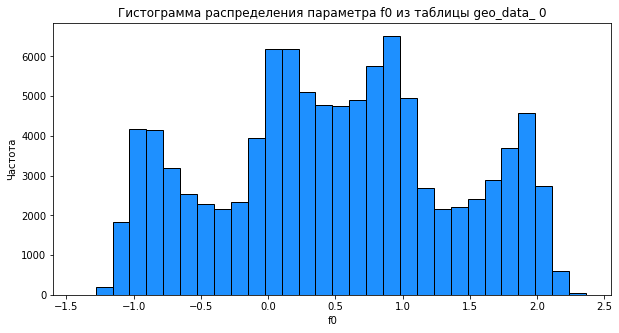

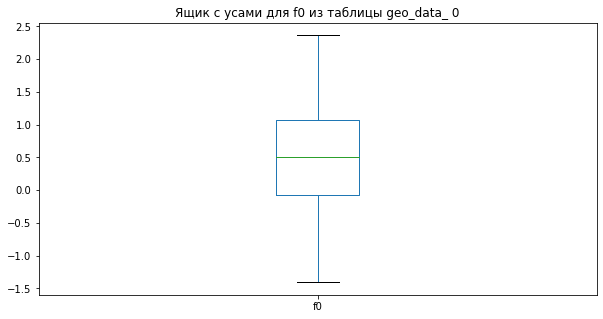

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


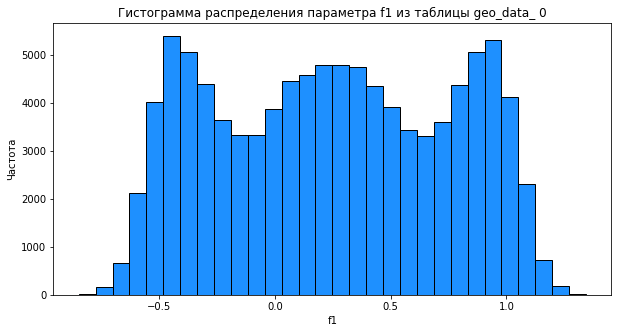

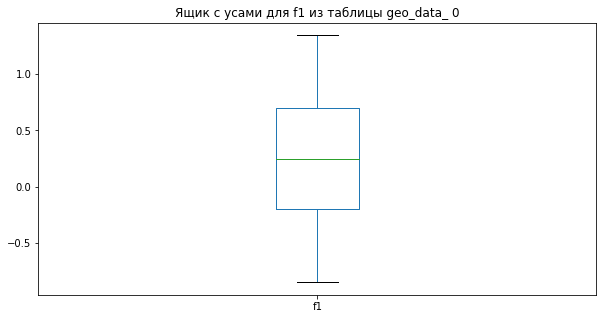

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


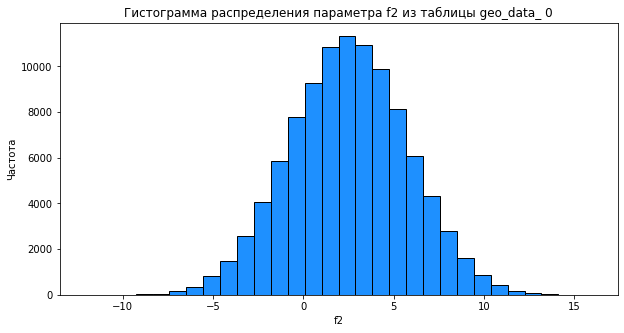

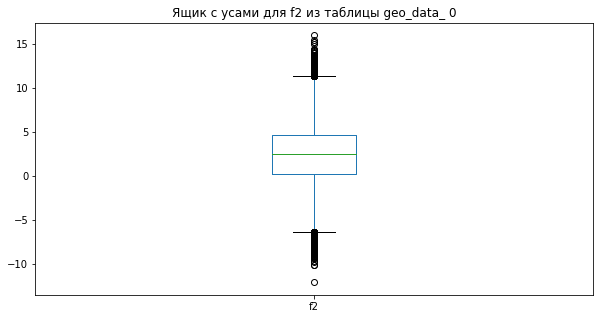

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


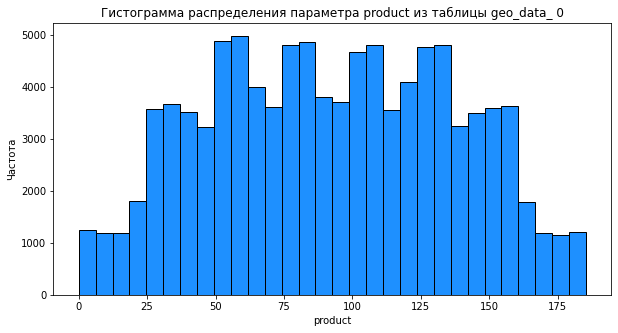

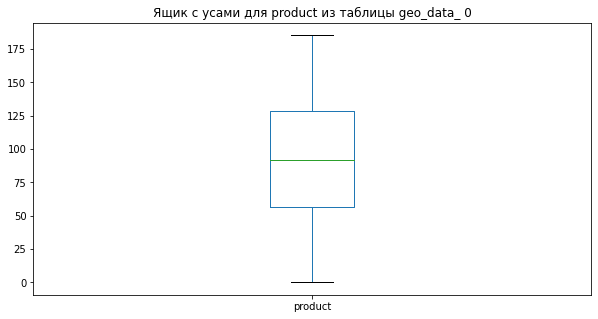

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


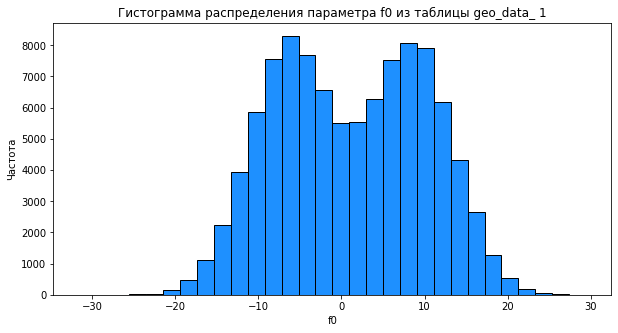

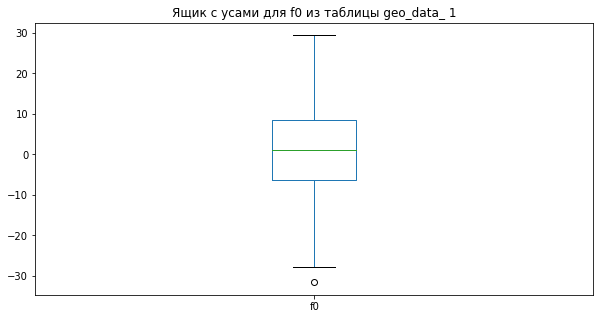

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


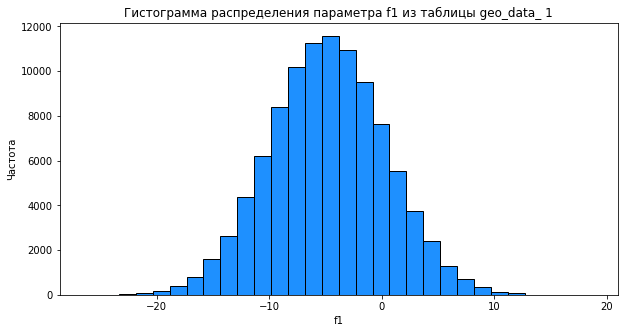

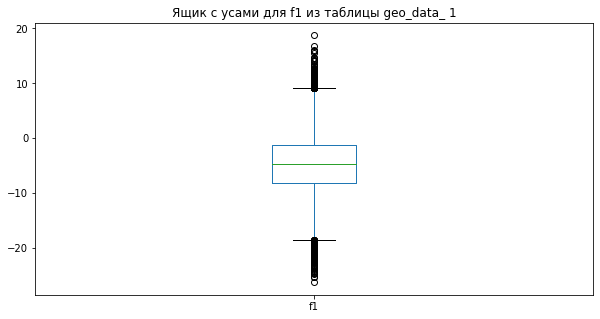

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


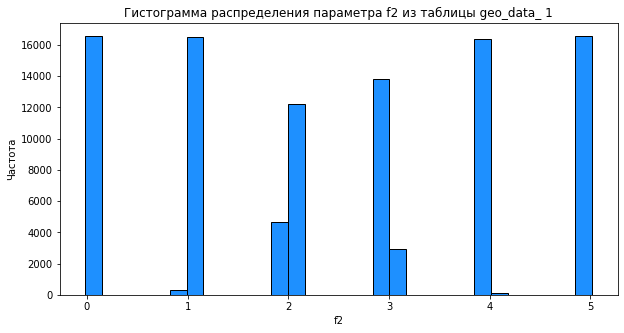

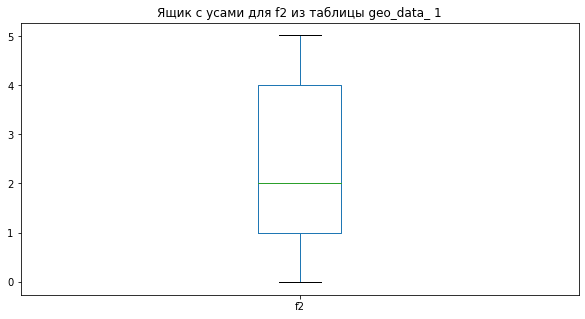

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


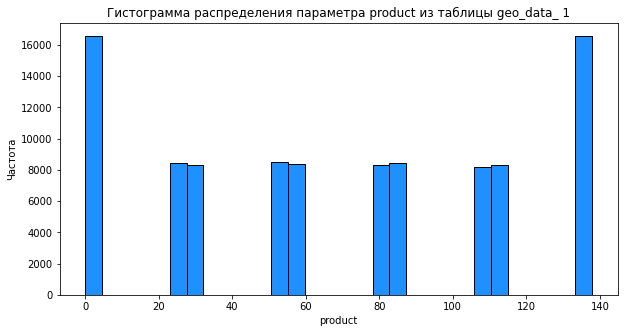

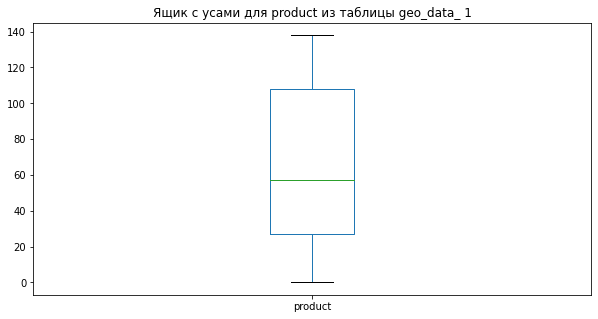

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


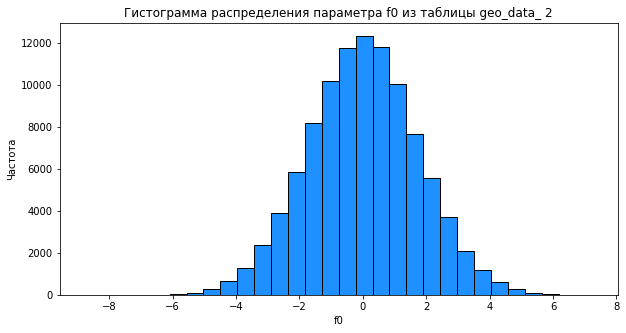

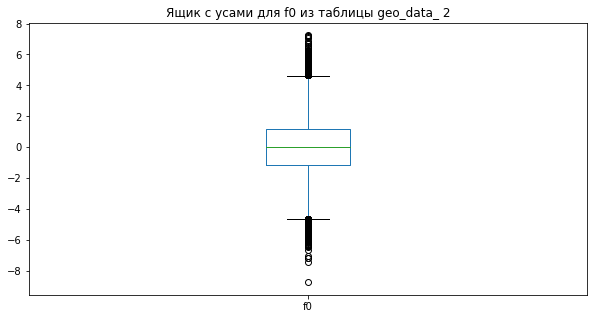

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


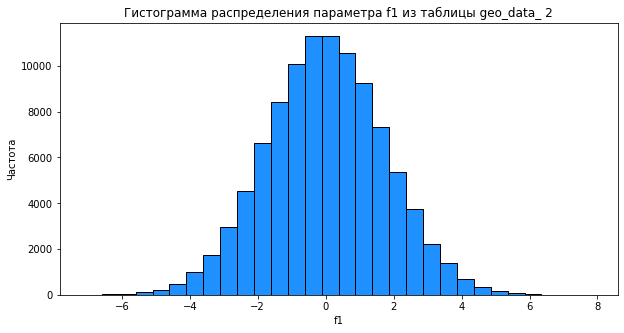

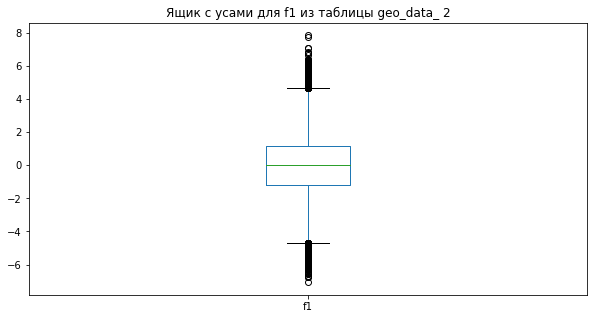

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


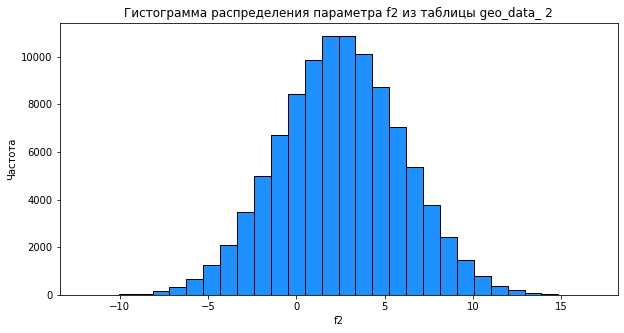

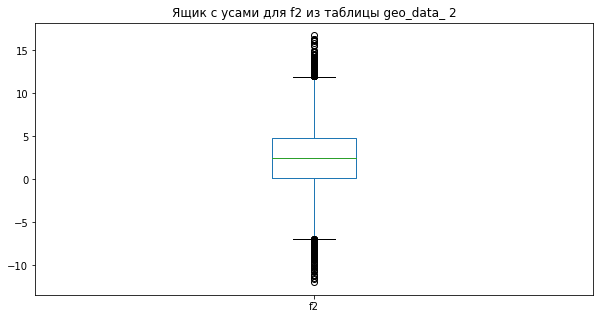

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


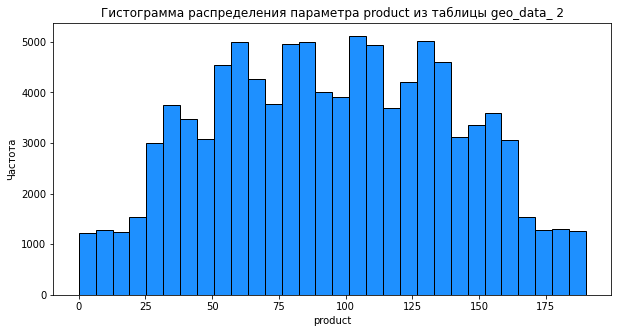

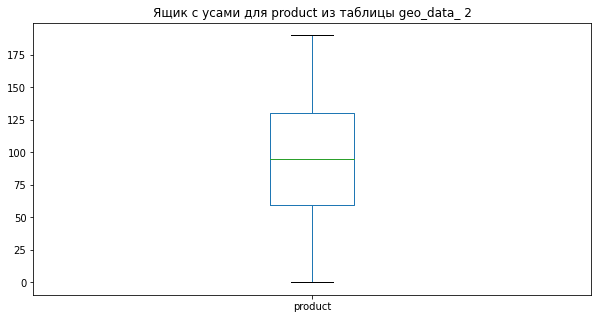

In [9]:
# Используем функцию для исследовательского анализа количественных признаков
def describe_numeric(dataframe, param, bins=30, color='violet'):
    """ A function for exploratory analysis of numeric parameters"""
    
    # Описательная статистика
    print(dataframe[param].describe())
    
    # Гистограмма
    plt.figure(figsize=(10, 5))
    plt.hist(dataframe[param], bins=bins, color='dodgerblue', edgecolor='black')
    plt.title(f'Гистограмма распределения параметра {param} из таблицы {dataframe.name}')
    plt.xlabel(f'{param}')
    plt.ylabel('Частота')
    plt.show()
    
    # Ящик с усами
    plt.figure(figsize=(10, 5))
    dataframe[param].plot.box(title=f'Ящик с усами для {param} из таблицы {dataframe.name}')
    plt.show()

for index, table in enumerate(table_list):
    table.name = f'geo_data_ {index}' 
for table in table_list:
    for parameter in geo_data_0.drop(columns=['id']).columns.tolist():
        describe_numeric(table, parameter)

Данных достаточно для анализа, выбросов и аномалий нет.  
Все признаки количественные, при этом, скорее всего, все они непрерывные. Для таблицы geo_data_1 f2 - выглядит дискретным, при этом в других регионах f2 - непрерывный. Это может быть связано с некой погрешностью измерений в регионе 1: возможно, методы исследований, которые подходят для региона 0 и 2, не подходят для региона 1.  

Для региона 0 (geo_data_0):  
 
- f0 - принимает значения от -1.40 до 2.36, среднее 0.50. По наличию нескольких мод можно предположить, что данные внутри признака делятся на группы.  
- f1 - принимает значения от -0.84 до 1.34, среднее 0.25. Бимодальное распределение.
- f2 - принимает значения от -12.09 до 16, среднее 2.50, имеет нормальное распределение.
- product - принимает значения от 0 до 185.36 тыс. баррелей, распределение близко к нормальному.   

Для региона 1 (geo_data_1):  

- f0 - принимает значения от -31.61 до 29.42, среднее 1.14. Бимодальное распределение.
- f1 - принимает значения от -26.36 до 18.73, среднее -4.8. Нормальное распределение.
- f2 - принимает значения от -0.02 до 5.02, среднее 2.49, данные распределяются на 6 групп. Возможно, это связано с методом исследования региона, дающем очень высокую погрешность для геологических отложений именно этого региона.
- product - принимает значения от 0 до 137.95 тыс. баррелей, запасы делятся на группы, скорее всего, из-за признака f2.  

Для региона 2 (geo_data_2):  

- f0 - принимает значения от -8.76 до 7.24, среднее 0.00. Нормальное распределение.
- f1 - принимает значения от -7.08 до 7.84, среднее -0.00. Нормальное распределение.
- f2 - принимает значения от -11.97 до 16.74, среднее 2.50, имеет нормальное распределение.
- product - принимает значения от 0 до 190.03 тыс. баррелей, распределение близко к нормальному.   



Исследуем взаимосвязь между признаками c помощью коэффициента корреляции Пирсона, так как все признаки количественные и предполагается использование линейной модели.

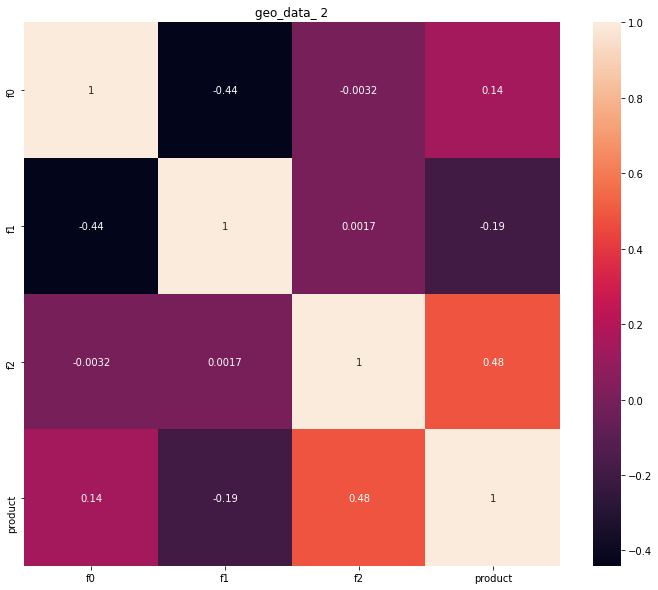

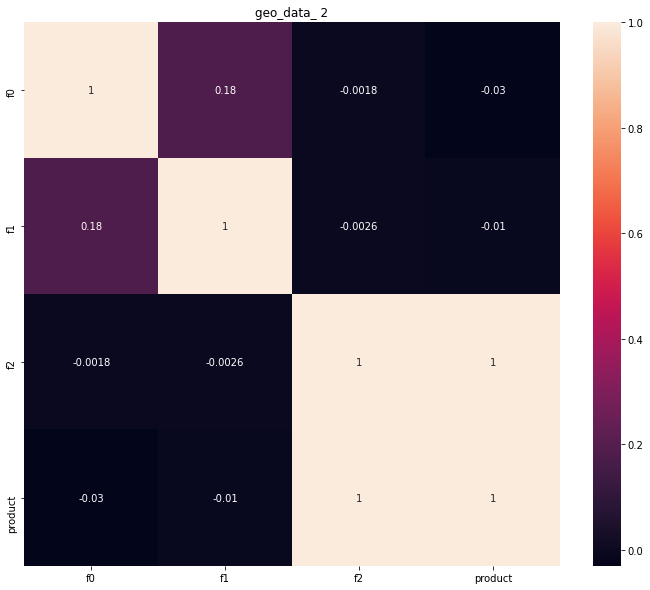

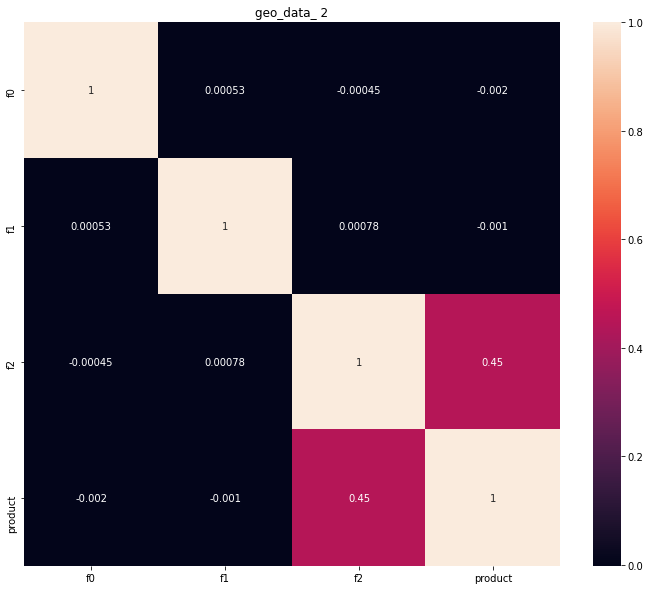

In [10]:
columns = ['f0', 'f1', 'f2', 'product']
def phik_corr(dataframe):
    """ The function returns Pearson correlation matrix for each dataframe"""
    plt.figure(figsize=(12,10))
    plt.title(f'geo_data_ {index}')
    sns.heatmap(dataframe[columns].corr(), annot=True)
    plt.show()
for table in table_list:
    phik_corr(table)

Мультиколлинеарности между входными признаками нет. Самое высокое влияние на запасы имеет признак f2. Для региона 1 (geo_data_1) он полностью влияет на целевой признак. Не совсем понятно, как это может быть в реальности...

## Обучение и проверка модели

Для предсказания объема запасов подготовим 3 модели для трех регионов, чтобы выбрать наиболее прибыльный регион.

In [11]:
# Обучим и оценим модели
def train_evaluate_model(dataframe):
    """Функция для подготовки данных для обучения моделей, обучение моделей линейной регрессии,
    предсказание значений и оценка качества предсказаний"""
    # Подготовка данных
    features = dataframe[['f0', 'f1', 'f2']]
    target = dataframe['product']
    
    # Разделение данных на обучающую и валидационную выборки (75:25)
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)
    # Нормализация данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    # Инициализация и обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    # Предсказание целевого признака и оценка качества модели
    predictions = model.predict(X_valid_scaled)
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mean_predicted_product = predictions.mean()
    r2 = r2_score(y_valid, predictions)
    
    return predictions, y_valid, rmse, mean_predicted_product, r2

results = {}
all_results = []

# Вызов функции для каждого региона
for table in table_list:
    predictions, y_valid, rmse, mean_predicted_product, r2 = train_evaluate_model(table)

    # Сохранение результатов в словарь
    results[table.name] = {
        'predictions': predictions,
        'real_values': y_valid,
        'RMSE': rmse,
        'mean_predicted_product': mean_predicted_product,
        'R2': r2
    }
    table_name = table.name.replace(' ', '')
    region_df = pd.DataFrame({
        'region': table_name,
        'real': y_valid,
        'predicted': predictions
    })
    all_results.append(region_df)
    
     

In [12]:
print('\nИтоговые результаты по всем регионам:')
for region, metrics in results.items():
    print(f'\nРегион: {region}')
    print(f'Средние запасы предсказанного сырья: {round(metrics["mean_predicted_product"])} тыс. баррелей')
    print(f'RMSE модели: {metrics["RMSE"]}')
    print(f'R2 модели: {metrics["R2"]}')


Итоговые результаты по всем регионам:

Регион: geo_data_ 0
Средние запасы предсказанного сырья: 92 тыс. баррелей
RMSE модели: 37.75660035026169
R2 модели: 0.2728287328173471

Регион: geo_data_ 1
Средние запасы предсказанного сырья: 69 тыс. баррелей
RMSE модели: 0.8902801001028846
R2 модели: 0.9996245232002449

Регион: geo_data_ 2
Средние запасы предсказанного сырья: 95 тыс. баррелей
RMSE модели: 40.145872311342174
R2 модели: 0.19634705977280487


Обучены модели линейной регрессии для каждого из регионов. С помощью метрики RMSE оценено качество моделей на валидационной выборке.  

Наименьшая среднеквадратичная ошибка RMSE для региона 1 - наиболее точное предсказание запасов для региона 1 является самым минимальным по всем регионам (69 тыс. баррелей). 
Для ориентира также сравним модели по коэффициентам детерминации R2 - самая точная модель все так же для региона 1.  
Средние запасы для региона 2 максимальны и составляют 95 тыс. баррелей, но и сравнительно высокая ошибка RMSE - 40 тыс.баррелей, что делает модель неточной.

## Подготовка к расчёту прибыли

Сохраним ключевые значения в отдельных переменных, также создадим датафрейм с предсказанными и истинными значениями запасов по регионам.

In [13]:
# Бюджет в рублях
budget = 10 * 10**9

# Доход с одной тысячи баррелей
thousand_barrel_revenue = 450000

# Количество разрабатываемых скважин
best_wells = 200

# Количество скважин в регионе
n_wells = 500

# Количество итераций бутстрепа
n_iterations=1000

# Обозначим константу для воспроизводимости при каждом новом вызове
state = np.random.RandomState(12345)

# Создаём датафрейм с реальными и предсказанными значениями
final_results = pd.concat(all_results, ignore_index=True)
final_results.head()

,region,real,predicted
0,geo_data_0,122.073350,101.901017
1,geo_data_0,48.738540,78.217774
2,geo_data_0,131.338088,115.266901
3,geo_data_0,88.327757,105.618618
4,geo_data_0,36.959266,97.980185


Рассчитаем минимальный объем запасов скважины для безубыточной разработки новой скважины.

In [14]:
# так как бюджет на планируемые 200 скважин известен, то каждая скважина должна приносить доход больше, 
# чем требуется для ее разработки
min_product_for_profit = budget / (best_wells * thousand_barrel_revenue)
print(f'Достаточный объём запасов в новой скважине для безубыточности: {round(min_product_for_profit)} тыс. баррелей')

Достаточный объём запасов в новой скважине для безубыточности: 111 тыс. баррелей


Расчитаем средний объем запасов по регионам.

In [15]:
reserves = final_results.groupby('region')['real'].mean()
reserves

region
geo_data_0    92.325956
geo_data_1    68.725381
geo_data_2    95.150999
Name: real, dtype: float64

Если скважины в регионе должны обладать запасами не менее 111 тысяч баррелей, все регионы являются убыточными по среднему значению запасов. Однако выбирать для разработки будут 200 лучших: это значит, что среднее значение для них будет выше.   

Подготовим функцию по расчету прибыли по 200 лучшим скважинам.

In [16]:
# Функция для расчета прибыли
def calculate_profit(df, region):
    # Выбираем регион
    region = df[df['region']== region]
    
    # Список для хранения результатов прибыли
    profit_distribution = []
    
    for i in range(n_iterations):
        # Семплируем 500 скважин с возвращением
        sampled_data = region.sample(n=n_wells, replace=True, random_state=state)
    
        # Сохраняем индексы лучших (топ-200) по предсказаниям запасов скважин
        top_wells = sampled_data.sort_values(by='predicted', ascending=False).head(best_wells)
    
        # Находим реальные суммарные запасы в лучших скважинах
        total_real_product = top_wells['real'].sum()
    
        # Выручка с 200 лучших скважин в рублях
        revenue_top_200 = total_real_product * thousand_barrel_revenue
    
        # Прибыль с 200 лучших скважин в рублях
        profit = revenue_top_200 - budget 
    
        # Сохраняем результат в список
        profit_distribution.append(profit)
        
    # Преобразовываем список в объект Series
    profit_distribution = pd.Series(profit_distribution)
    
    return profit_distribution

Все значения, необходимые для расчета прибыли от добычи нефти, сохранены в отдельных переменных.  
Рассчитан минимальный объем запасов, которым должна обладать скважина для безубыточной разработки - 111 тыс. баррелей.  
Если скважины в регионе должны обладать запасами не менее 111 тысяч баррелей, все регионы являются убыточными по среднему значению запасов в целом по региону. Однако выбирать для разработки будут 200 лучших: это значит, что среднее значение для них будет выше.  
Для расчета прибыли для 200 лучших скважин подготовлена функция calculate_profit, возвращающая распределение прибыли для 200 лучших скважин отдельного региона.

## Расчёт прибыли и рисков 

Оценим каждый регион по средней прибыли от разработки 200 лучших по региону скважин, по 95%-му доверительному интервалу прибыли и по риску убытков.

In [17]:
def define_profit_risks(profit_distribution_region, region_index):
    """ Функция, определяющая среднюю прибыль, 95% доверительный интервал и риск убытков для региона"""
    # Средняя прибыль
    mean = profit_distribution_region.mean()
    
    # 95%-й доверительный интервал
    lower = profit_distribution_region.quantile(0.05)
    upper = profit_distribution_region.quantile(0.95)
    
    # Риск убытков (доля отрицательных значений прибыли)
    risk = (profit_distribution_region < 0).mean()
    
    # Создаем таблицу с результатами
    results_table = pd.DataFrame({
        'Регион': [region_index],
        'Средняя прибыль (млн.руб)': [mean // 10**6],
        '95% доверительный интервал - от (млн.руб)': [lower // 10**6],
        '95% доверительный интервал - до (млн.руб)': [upper // 10**6],
        'Риск убытков (%)': [risk * 100]
    })
    
    return results_table

In [18]:
# Вызовем подготовленные ранее функции и отобразим результат в общем датафрейме final_results_table
profit_0 = calculate_profit(final_results, 'geo_data_0')
profit_1 = calculate_profit(final_results, 'geo_data_1')
profit_2 = calculate_profit(final_results, 'geo_data_2')

region_0_summary = define_profit_risks(profit_0, 0)
region_1_summary = define_profit_risks(profit_1, 1)
region_2_summary = define_profit_risks(profit_2, 2)
final_results_table = pd.concat([region_0_summary, region_1_summary, region_2_summary], ignore_index=True)

In [22]:
final_results_table.sort_values(by='Средняя прибыль (млн.руб)', ascending=False)

,Регион,Средняя прибыль (млн.руб),95% доверительный интервал - от (млн.руб),95% доверительный интервал - до (млн.руб),Риск убытков (%)
1,1,441.0,106.0,774.0,1.6
0,0,406.0,-50.0,847.0,6.7
2,2,385.0,-75.0,822.0,7.8


По 200 лучшим скважинам в трех регионах оценена средняя прибыль в миллионах рублей, 95% доверительный интервал распределения прибыли и риск убытков.  
- Для региона 0 средняя прибыль составляет 406 млн. рублей, с вероятностью 95% прибыль (начиная с убытка) распределяется от -50 до 847 млн. рублей; риск убытков равен 6.7%, что много для заданного условия.
- Для региона 1 максимальная средняя прибыль среди всех регионов, она составляет 441 млн. рублей. Прибыль распределена от 106 до 774 млн. рублей с 95% вероятностью. Риск убытков минимальный - 1.6%.
- Для региона 2 средняя прибыль 385 млн. рублей, 95% доверительный интервал распределения прибыли (убытков) от -75 до 822 млн. рублей. Риск убытков максимальный - составляет 7.8%.

Так как по условию для разработки подходят только регионы с риском убытков менее 2.5%, можно предложить для разработки только 1-ый регион с риском убытков 1.6%. Регион 1 также может принести максимальную из трех прибыль. 
Таким образом, к разработке рекомендуется именно 1 регион с данными геологазведки в таблице geo_data_1.

## Вывод

В результате выполнения проекта выбран регион, наиболее перспективный для добычи нефти. Для этого выполнено:
- Исходные данные проверены на корректность, отсутствие дубликатов и пропусков.   
- Проведен исследовательский анализ данных - проверено распределение данных, отсутствие аномалий, мультиколлинеарность между входными признаками.   
- Обучены модели линейной регрессии для каждого из регионов. С помощью метрики RMSE оценено качество моделей на валидационной выборке. Наименьшая среднеквадратичная ошибка RMSE для региона 1 - наиболее точное предсказание запасов для региона 1 является самым минимальным по всем регионам (69 тыс. баррелей).  
- Все значения, необходимые для расчета прибыли от добычи нефти, сохранены в отдельных переменных.  
- Рассчитан минимальный объем запасов, которым должна обладать скважина для безубыточной разработки - 111 тыс. баррелей. 
- По 200 лучшим скважинам в трех регионах оценена средняя прибыль в миллионах рублей, 95% доверительный интервал распределения прибыли и риск убытков.
- Для региона 1 максимальная средняя прибыль среди всех регионов, она составляет 441 млн. рублей. Прибыль распределена от 106 до 774 млн. рублей с 95% вероятностью. Риск убытков минимальный - 1.6%.   

Так как по условию задачи для разработки подходят только регионы с риском убытков менее 2.5%, можно предложить для разработки только 1-ый регион с риском убытков 1.6%. Регион 1 также может принести максимальную из трех регионов среднюю прибыль.   
Таким образом, к разработке рекомендуется именно 1 регион с данными геологазведки в таблице geo_data_1.